In [1]:
# Install required packages (if not already installed)
!pip install scikit-image

# %%
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog, local_binary_pattern, canny
from skimage.transform import resize
import time

# Load MNIST dataset
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target

# Convert to numpy arrays
X = np.array(X)
y = np.array(y).astype(int)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape to 28x28 images and normalize
X_train_images = X_train.reshape(-1, 28, 28) / 255.0
X_test_images = X_test.reshape(-1, 28, 28) / 255.0

print(f"Training set shape: {X_train_images.shape}")
print(f"Test set shape: {X_test_images.shape}")

Loading MNIST dataset...
Training set shape: (56000, 28, 28)
Test set shape: (14000, 28, 28)


In [2]:
# ### 2.1 Histogram of Oriented Gradients (HOG)

# %%
def extract_hog_features(images):
    features = []
    for image in images:
        fd = hog(image, orientations=8, pixels_per_cell=(4, 4),
                 cells_per_block=(1, 1), visualize=False)
        features.append(fd)
    return np.array(features)

print("Extracting HOG features...")
start_time = time.time()
X_train_hog = extract_hog_features(X_train_images)
X_test_hog = extract_hog_features(X_test_images)
hog_time = time.time() - start_time

print(f"HOG features shape - Train: {X_train_hog.shape}, Test: {X_test_hog.shape}")
print(f"Time taken: {hog_time:.2f} seconds")

# ### 2.2 Local Binary Patterns (LBP)

# %%
def extract_lbp_features(images, radius=3, n_points=24):
    features = []
    for image in images:
        lbp = local_binary_pattern(image, n_points, radius, method='uniform')
        hist, _ = np.histogram(lbp, bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)  # Normalize
        features.append(hist)
    return np.array(features)

print("Extracting LBP features...")
start_time = time.time()
X_train_lbp = extract_lbp_features(X_train_images)
X_test_lbp = extract_lbp_features(X_test_images)
lbp_time = time.time() - start_time

print(f"LBP features shape - Train: {X_train_lbp.shape}, Test: {X_test_lbp.shape}")
print(f"Time taken: {lbp_time:.2f} seconds")

# ### 2.3 Edge Detection (Canny)

# %%
def extract_edge_features(images, sigma=1.0):
    features = []
    for image in images:
        edges = canny(image, sigma=sigma)
        # Resize to make features consistent in size
        edges_resized = resize(edges, (14, 14), anti_aliasing=False)
        features.append(edges_resized.flatten())
    return np.array(features)

print("Extracting Edge features...")
start_time = time.time()
X_train_edge = extract_edge_features(X_train_images)
X_test_edge = extract_edge_features(X_test_images)
edge_time = time.time() - start_time

print(f"Edge features shape - Train: {X_train_edge.shape}, Test: {X_test_edge.shape}")
print(f"Time taken: {edge_time:.2f} seconds")


Extracting HOG features...
HOG features shape - Train: (56000, 392), Test: (14000, 392)
Time taken: 75.67 seconds
Extracting LBP features...


/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


LBP features shape - Train: (56000, 26), Test: (14000, 26)
Time taken: 37.19 seconds
Extracting Edge features...
Edge features shape - Train: (56000, 196), Test: (14000, 196)
Time taken: 42.52 seconds


In [3]:
# ## 3. Deep Learning-Based Feature Extraction

# %%
# Install TensorFlow if not already installed
!pip install tensorflow

# %%
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

def create_feature_extractor():
    # MobileNetV2 expects 3-channel images of at least 32x32
    input_tensor = Input(shape=(32, 32, 3))
    base_model = MobileNetV2(input_tensor=input_tensor,
                           include_top=False,
                           weights='imagenet',
                           pooling='avg')
    return Model(inputs=input_tensor, outputs=base_model.output)

def prepare_images_for_cnn(images):
    # Convert grayscale to RGB by repeating the channel
    images_rgb = np.repeat(images[..., np.newaxis], 3, axis=-1)
    # Resize to 32x32
    images_resized = np.array([resize(img, (32, 32)) for img in images_rgb])
    # Preprocess for MobileNetV2
    return preprocess_input(images_resized)

print("Preparing images for CNN...")
X_train_cnn = prepare_images_for_cnn(X_train_images)
X_test_cnn = prepare_images_for_cnn(X_test_images)

print("Creating feature extractor...")
feature_extractor = create_feature_extractor()

print("Extracting deep features...")
start_time = time.time()
X_train_deep = feature_extractor.predict(X_train_cnn, batch_size=128)
X_test_deep = feature_extractor.predict(X_test_cnn, batch_size=128)
deep_time = time.time() - start_time

print(f"Deep features shape - Train: {X_train_deep.shape}, Test: {X_test_deep.shape}")
print(f"Time taken: {deep_time:.2f} seconds")

# %% [markdown]


Preparing images for CNN...
Creating feature extractor...


<ipython-input-3-040e3086ec6b>:16: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_tensor=input_tensor,


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Extracting deep features...
438/438 ━━━━━━━━━━━━━━━━━━━━ 44s 97ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step
Deep features shape - Train: (56000, 1280), Test: (14000, 1280)
Time taken: 56.27 seconds


In [4]:
# ## 4. Classification and Evaluation

# %%
def train_and_evaluate(X_train, X_test, y_train, y_test, feature_name):
    print(f"\nTraining Random Forest with {feature_name} features...")
    start_time = time.time()

    # Train Random Forest
    clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)

    # Predictions
    y_pred = clf.predict(X_test)

    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    train_time = time.time() - start_time

    print(f"Results for {feature_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Training time: {train_time:.2f} seconds")

    return {
        'feature': feature_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'feature_extraction_time': globals().get(f"{feature_name.lower().replace(' ', '_')}_time", None),
        'training_time': train_time
    }

# Evaluate all feature extraction methods
results = []
results.append(train_and_evaluate(X_train_hog, X_test_hog, y_train, y_test, "HOG"))
results.append(train_and_evaluate(X_train_lbp, X_test_lbp, y_train, y_test, "LBP"))
results.append(train_and_evaluate(X_train_edge, X_test_edge, y_train, y_test, "Edge Detection"))
results.append(train_and_evaluate(X_train_deep, X_test_deep, y_train, y_test, "Deep Features"))


Training Random Forest with HOG features...
Results for HOG:
Accuracy: 0.9709
Precision: 0.9707
Recall: 0.9707
F1-Score: 0.9707
Training time: 66.34 seconds

Training Random Forest with LBP features...
Results for LBP:
Accuracy: 0.6077
Precision: 0.5919
Recall: 0.5996
F1-Score: 0.5926
Training time: 16.23 seconds

Training Random Forest with Edge Detection features...
Results for Edge Detection:
Accuracy: 0.8730
Precision: 0.8723
Recall: 0.8702
F1-Score: 0.8700
Training time: 17.04 seconds

Training Random Forest with Deep Features features...
Results for Deep Features:
Accuracy: 0.7871
Precision: 0.7842
Recall: 0.7839
F1-Score: 0.7833
Training time: 64.89 seconds


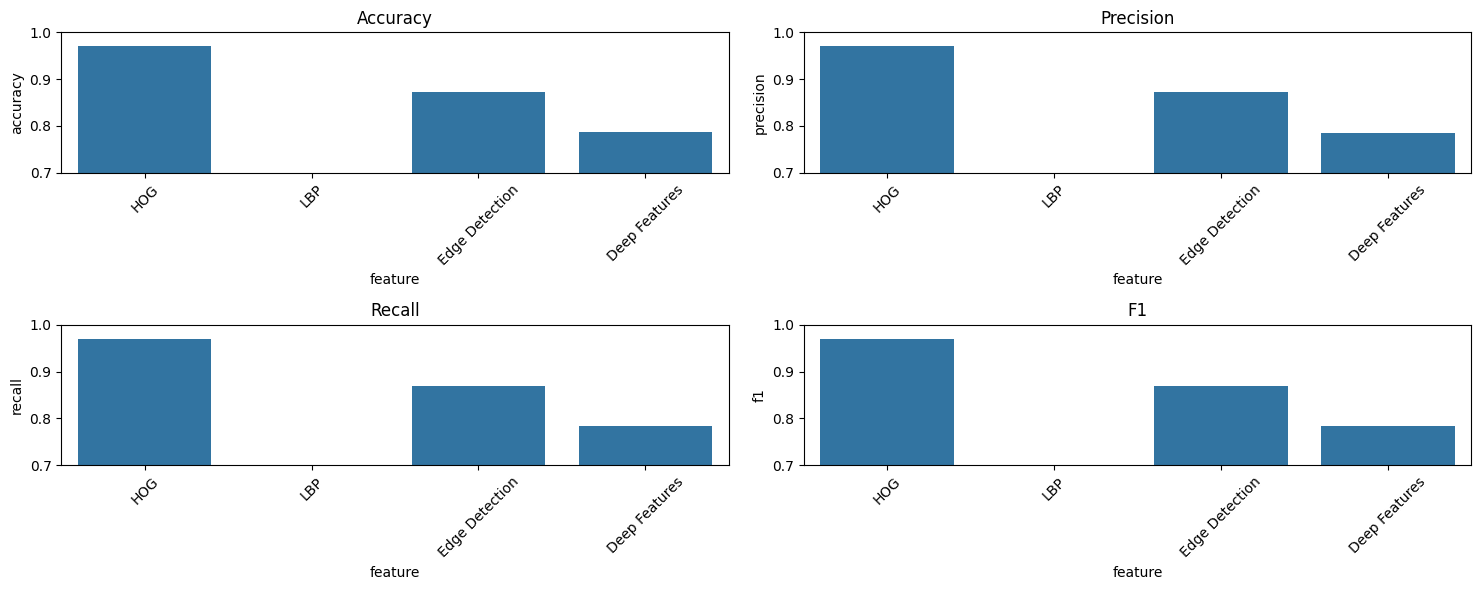


Performance Comparison:


,feature,accuracy,precision,recall,f1,feature_extraction_time,training_time
0,HOG,0.970857,0.970731,0.970747,0.970677,75.674351,66.340840
1,LBP,0.607714,0.591866,0.599552,0.592634,37.185213,16.225114
2,Edge Detection,0.873000,0.872317,0.870219,0.870010,NaN,17.037321
3,Deep Features,0.787071,0.784170,0.783926,0.783291,NaN,64.885618


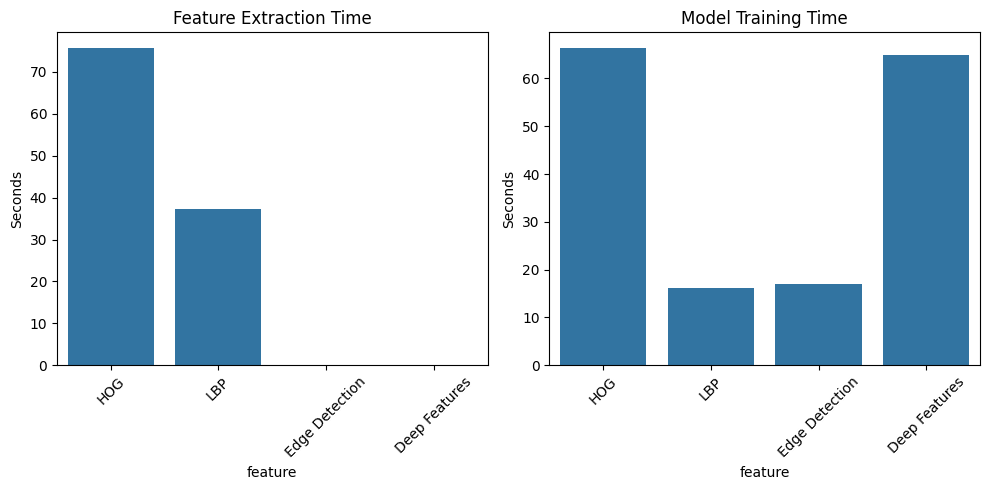

In [5]:
# ## 5. Results Comparison

# %%
import pandas as pd
import seaborn as sns

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plot comparison
plt.figure(figsize=(15, 6))
metrics = ['accuracy', 'precision', 'recall', 'f1']
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='feature', y=metric, data=results_df)
    plt.title(metric.capitalize())
    plt.xticks(rotation=45)
    plt.ylim(0.7, 1.0)
plt.tight_layout()
plt.show()

# Display full results table
print("\nPerformance Comparison:")
display(results_df)

# Plot timing information
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.barplot(x='feature', y='feature_extraction_time', data=results_df)
plt.title('Feature Extraction Time')
plt.xticks(rotation=45)
plt.ylabel('Seconds')

plt.subplot(1, 2, 2)
sns.barplot(x='feature', y='training_time', data=results_df)
plt.title('Model Training Time')
plt.xticks(rotation=45)
plt.ylabel('Seconds')

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


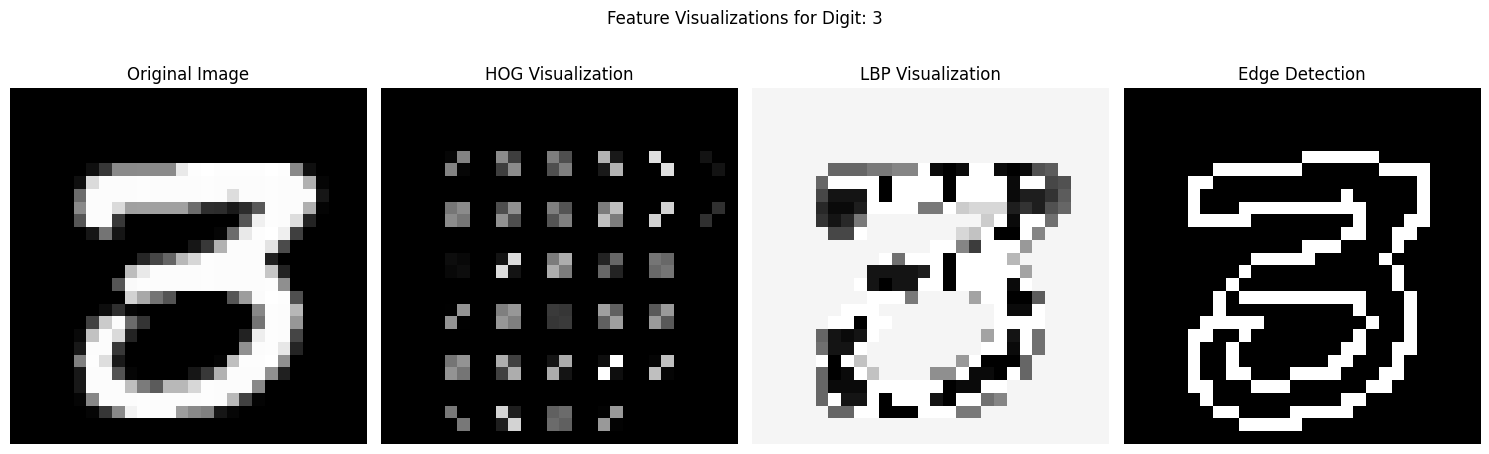

In [6]:
# ## 6. Feature Visualizations

# %%
# Visualize features for a sample image
sample_idx = 42  # You can change this index to see different samples

plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 4, 1)
plt.imshow(X_train_images[sample_idx], cmap='gray')
plt.title("Original Image")
plt.axis('off')

# HOG features
fd, hog_image = hog(X_train_images[sample_idx], orientations=8, pixels_per_cell=(4, 4),
                   cells_per_block=(1, 1), visualize=True)
plt.subplot(1, 4, 2)
plt.imshow(hog_image, cmap='gray')
plt.title("HOG Visualization")
plt.axis('off')

# LBP features
lbp = local_binary_pattern(X_train_images[sample_idx], 24, 3, method='uniform')
plt.subplot(1, 4, 3)
plt.imshow(lbp, cmap='gray')
plt.title("LBP Visualization")
plt.axis('off')

# Edge features
edges = canny(X_train_images[sample_idx], sigma=1.0)
plt.subplot(1, 4, 4)
plt.imshow(edges, cmap='gray')
plt.title("Edge Detection")
plt.axis('off')

plt.suptitle(f"Feature Visualizations for Digit: {y_train[sample_idx]}")
plt.tight_layout()
plt.show()